<a href="https://colab.research.google.com/github/Leehong-DENG/CBIG/blob/master/tutorials/W2D2_LinearSystems/student/W2D2_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3: Combining determinism and stochasticity
**Week 2, Day 2: Linear Systems**

**By Neuromatch Academy**

**Content Creators**: Bing Wen Brunton, Alice Schwarze, Biraj Pandey

**Content Reviewers**: Norma Kuhn, John Butler, Matthew Krause, Ella Batty, Richard Gao, Michael Waskom

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

*Estimated timing of tutorial: 45 minutes*

Time-dependent processes rule the world. 

Now that we've spent some time familiarizing ourselves with the behavior of such systems when their trajectories are (1) entirely predictable and deterministic, or (2) governed by random processes, it's time to consider that neither is sufficient to describe neuroscience. Instead, we are often faced with processes for which we know some dynamics, but there is some random aspect as well. We call these **dynamical systems with stochasticity**.

This tutorial will build on our knowledge and gain some intuition for how deterministic and stochastic processes can both be a part of a dynamical system by:
* Simulating random walks 
* Investigating the mean and variance of a Ornstein-Uhlenbeck (OU) process
* Quantifying the OU process's behavior at equilibrium.

In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/snv4m/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

In [2]:
# Imports

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [5]:
# @title Plotting Functions
# drift-diffusion model
# returns t, x

def plot_random_walk_sims(sims, nsims=10):
  """Helper for exercise 3A"""
  fig = plt.figure()
  plt.plot(sim[:nsims, :].T)
  plt.xlabel('time')
  plt.ylabel('position x')
  plt.show()

def plot_mean_var_by_timestep(mu, var):
  """Helper function for exercise 3A.2"""
  fig, (ah1, ah2) = plt.subplots(2)

  # plot mean of distribution as a function of time
  ah1.plot(mu)
  ah1.set(ylabel='mean')
  ah1.set_ylim([-5, 5])

  # plot variance of distribution as a function of time
  ah2.plot(var)
  ah2.set(xlabel='time')
  ah2.set(ylabel='variance')

  plt.show()

def plot_ddm(t, x, xinfty, lam, x0):
  fig = plt.figure()

  plt.plot(t, xinfty * (1 - lam**t) + x0 * lam**t, 'r')
  plt.plot(t, x, 'k.')          # simulated data pts

  plt.xlabel('t')
  plt.ylabel('x')

  plt.legend({'deterministic solution', 'simulation'})
  plt.show()

def var_comparison_plot(empirical, analytical):
  fig = plt.figure()
  plt.plot(empirical, analytical, '.', markersize=15)
  plt.xlabel('empirical equilibrium variance')
  plt.ylabel('analytic equilibrium variance')
  plt.plot(np.arange(8), np.arange(8), 'k', label='45 deg line')
  plt.legend()

  plt.grid(True)
  plt.show()

def plot_dynamics(x, t, lam, xinfty=0):
  """ Plot the dynamics """
  fig = plt.figure()
  plt.title('$\lambda=%0.1f$' % lam, fontsize=16)
  x0 = x[0]
  plt.plot(t, xinfty + (x0 - xinfty) * lam**t, 'r', label='analytic solution')
  plt.plot(t, x, 'k.', label='simulation')          # simulated data pts
  plt.ylim(0, x0+1)

  plt.xlabel('t')
  plt.ylabel('x')
  plt.legend()
  plt.show()

---
# Section 1: Random Walks


In [6]:
# @title Video 1: E. coli and Random Walks
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1LC4y1h7gD", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="VHwTBCQJjfw", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

To begin, let's first take a gander at how life sometimes wanders around aimlessly. One of the simplest and best-studied living systems that has some interesting behaviors is the _E. coli_ bacterium, which is capable of navigating odor gradients on a substrate to seek a food source. Larger life (including flies, dogs, and blindfolded humans) sometimes use the same strategies to guide their decisions.

Here, we will consider what the _E. coli_ does in the absence of food odors. What's the best strategy when one does not know where to head? Why, flail around randomly, of course!

The **random walk** is exactly that --- at every time step, use a random process like flipping a coin to change one's heading accordingly. Note that this process is closely related to _Brownian motion_, so you may sometimes hear that terminology used as well.

Let's start with a **one-dimensional random walk**. A bacterium starts at $x=0$. At every time step, it flips a coin (a very small, microscopic coin of protein mintage), then heads left $\Delta x = -1$ or right $\Delta x = +1$ for with equal probability. For instance, if at time step $1$ the result of the coin flip is to head right, then its position at that time step becomes $x_1 = x_0 + \Delta x = 1.$ Continuing in this way, its position at time step $k+1$ is given by 
$$x_{k+1} = x_k + \Delta x $$    

We will simulate this process below and plot the position of the bacterium as a function of the time step. 

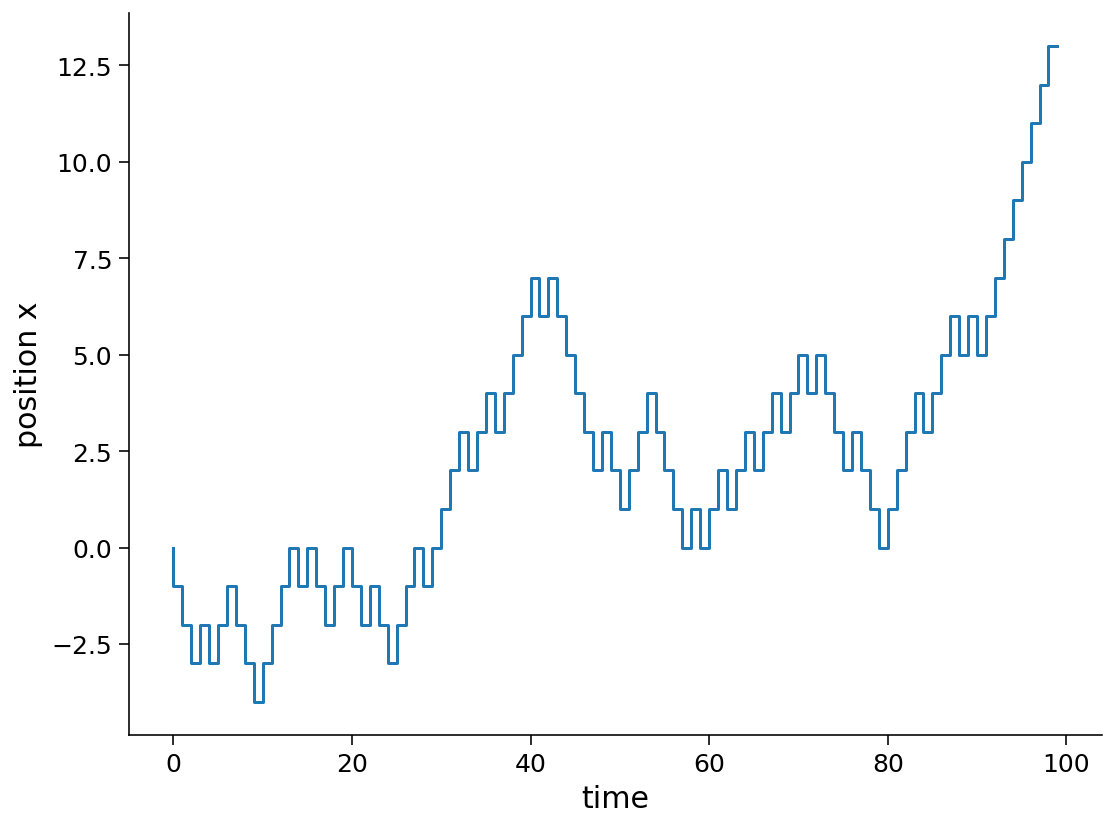

In [12]:
# @markdown Execute to simulate a random walk
# parameters of simulation
T = 100
t = np.arange(T)
x = np.zeros_like(t)
# np.random.seed(2020) # set random seed

# initial position
x[0] = 0

# step forward in time
for k in range(len(t)-1):
    # choose randomly between -1 and 1 (coin flip)
    this_step = np.random.choice([-1,1])

    # make the step
    x[k+1] = x[k] + this_step

# plot this trajectory
fig = plt.figure()
plt.step(t, x)
plt.xlabel('time')
plt.ylabel('position x');

## Coding Exercise 1A: Random walk simulation

*Referred to in video as exercise 3A*

In the previous plot, we assumed that the bacterium takes a step of size $1$ at every point in time. Let's let it take steps of different sizes!

We will code a random walk where the steps have a standard normal distribution (with mean $\mu$ and standard deviation $\sigma$). Instead of running one trajectory at a time, we will write our code so that we can simulate a large number of trajectories efficiently. We will combine this all into a function ``random_walk_simulator`` that generates $N$ random walks each with $T$ time points efficiently.

We will plot 10 random walks for 10000 time steps each.

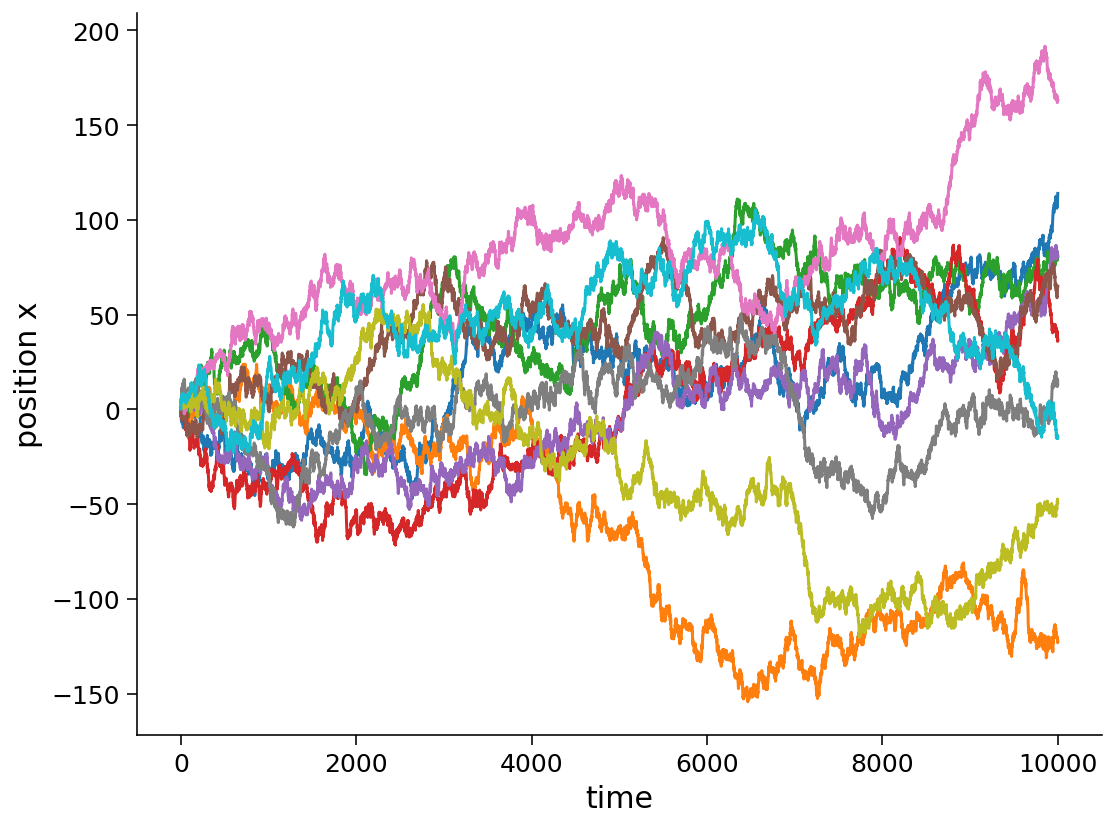

In [13]:
def random_walk_simulator(N, T, mu=0, sigma=1):
    '''Simulate N random walks for T time points. At each time point, the step
       is drawn from a Gaussian distribution with mean mu and standard deviation
       sigma.

    Args:
      T (integer) : Duration of simulation in time steps
      N (integer) : Number of random walks
      mu (float) : mean of step distribution
      sigma (float) : standard deviation of step distribution

    Returns:
      (numpy array) : NxT array in which each row corresponds to trajectory
    '''

    ###############################################################################
    ## TODO: Code the simulated random steps to take
    ## Hints: you can generate all the random steps in one go in an N x T matrix
    ## raise NotImplementedError('Complete random_walk_simulator_function')
    ###############################################################################
    # generate all the random steps for all steps in all simulations in one go
    # produces a N x T array
    steps = np.random.normal(mu, sigma, size=(N, T))

    # compute the cumulative sum of all the steps over the time axis
    sim = np.cumsum(steps, axis=1)

    return sim

np.random.seed(2020) # set random seed

# simulate 1000 random walks for 10000 time steps
sim = random_walk_simulator(1000, 10000,  mu=0, sigma=1)

# take a peek at the first 10 simulations
plot_random_walk_sims(sim, nsims=10)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D2_LinearSystems/solutions/W2D2_Tutorial3_Solution_4265c9d0.py)

*Example output:*

<img alt='Solution hint' align='left' width=1120.0 height=832.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D2_LinearSystems/static/W2D2_Tutorial3_Solution_4265c9d0_0.png>



We see that the trajectories all look a little different from each other. But there are some general observations one can make: at the beginning almost all trajectories are very close to $x=0$, which is where our bacterium started. As time progresses, some trajectories move further and further away from the starting point. However, a lot of trajectories stay close to the starting point of $x=0$. 

Now let's take a look in the next cell at the distribution of bacteria positions at different points in time, analyzing all the trajectories we just generated above. 

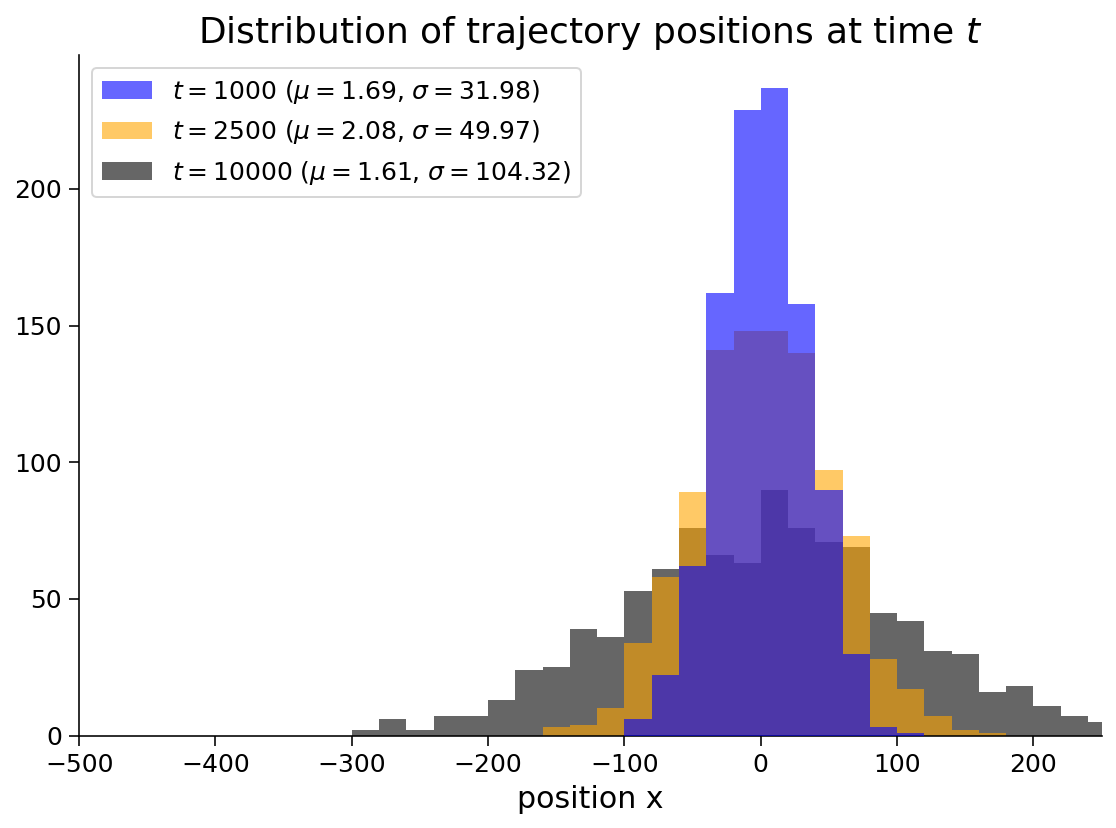

In [14]:
# @markdown Execute to visualize distribution of bateria positions
fig = plt.figure()
# look at the distribution of positions at different times
for i, t in enumerate([1000,2500,10000]):

    # get mean and standard deviation of distribution at time t
    mu = sim[:, t-1].mean()
    sig2 = sim[:, t-1].std()

    # make a plot label
    mytitle = '$t=${time:d} ($\mu=${mu:.2f}, $\sigma=${var:.2f})'

    # plot histogram
    plt.hist(sim[:,t-1],
             color=['blue','orange','black'][i],
             #make sure the histograms have the same bins!
             bins=np.arange(-300,300,20),
             # make histograms a little see-through
             alpha=0.6,
             # draw second histogram behind the first one
             zorder=3-i,
             label=mytitle.format(time=t, mu=mu, var=sig2))

    plt.xlabel('position x')

    # plot range
    plt.xlim([-500, 250])

    # add legend
    plt.legend(loc=2)

    # add title
    plt.title(r'Distribution of trajectory positions at time $t$')

At the beginning of the simulation, the distribution of positions is sharply peaked about $0$. As time progresses, the distribution becomes wider but its center stays closer to $0$. In other words, the mean of the distribution is independent of time, but the variance and standard deviation of the distribution scale with time. Such a process is called a **diffusive process**.


## Coding Exercise 1B: Random walk mean & variance

Compute and then plot the mean and variance of our bacterium's random walk as a function of time.

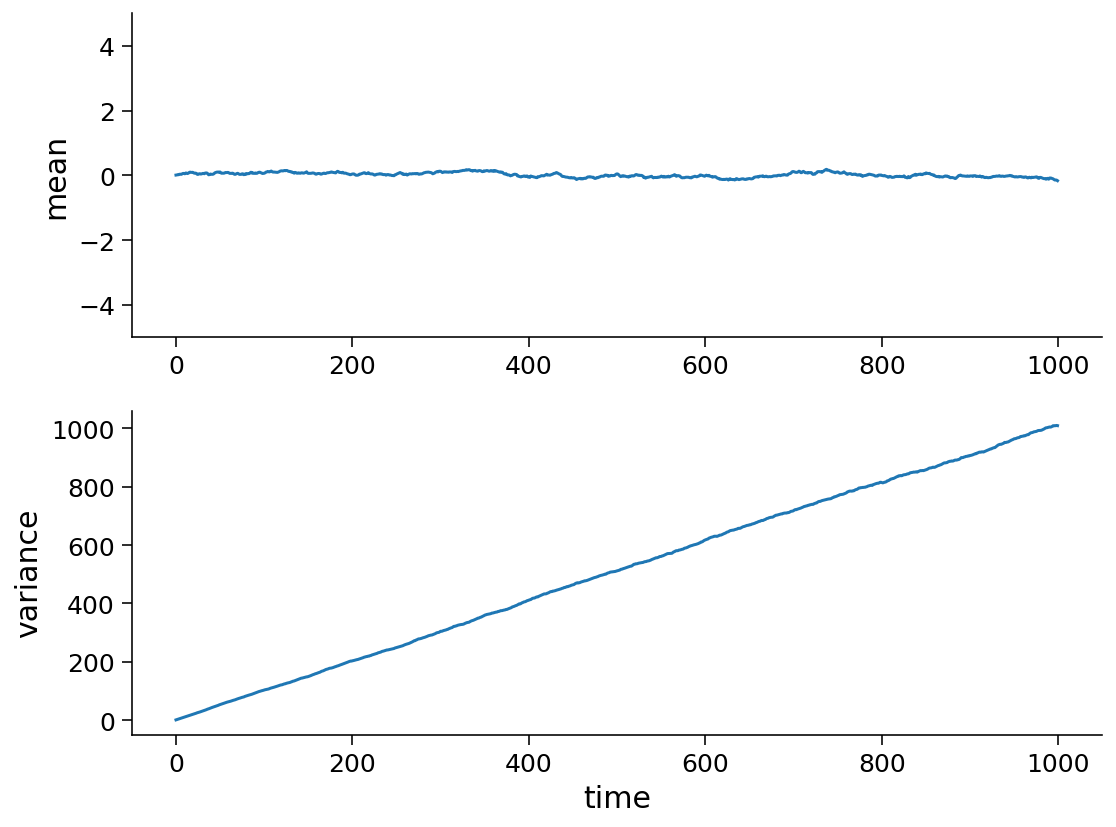

In [19]:
# Simulate random walks
## np.random.seed(2020) # set random seed
sim = random_walk_simulator(5000, 1000, mu=0, sigma=1)

##############################################################################
# TODO: Insert your code here to compute the mean and variance of trajectory positions
# at every time point:
## raise NotImplementedError("Student exercise: need to compute mean and variance")
##############################################################################

# Compute mean
mu = np.mean(sim, axis=0)

# Compute variance
var = np.var(sim, axis=0)

# Visualize
plot_mean_var_by_timestep(mu, var)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D2_LinearSystems/solutions/W2D2_Tutorial3_Solution_796a6346.py)

*Example output:*

<img alt='Solution hint' align='left' width=1120.0 height=832.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D2_LinearSystems/static/W2D2_Tutorial3_Solution_796a6346_0.png>



The expected value of $x$ stays close to 0, even for random walks of very long time. Cool!

The variance, on the other hand, clearly increases with time. In fact, the variance seems to increase linearly with time!


## Interactive Demo 1: Influence of Parameter Choice

 How do the parameters $\mu$ and $\sigma$ of the Gaussian distribution from which we choose the steps affect the mean and variance of the bacterium's random walk?

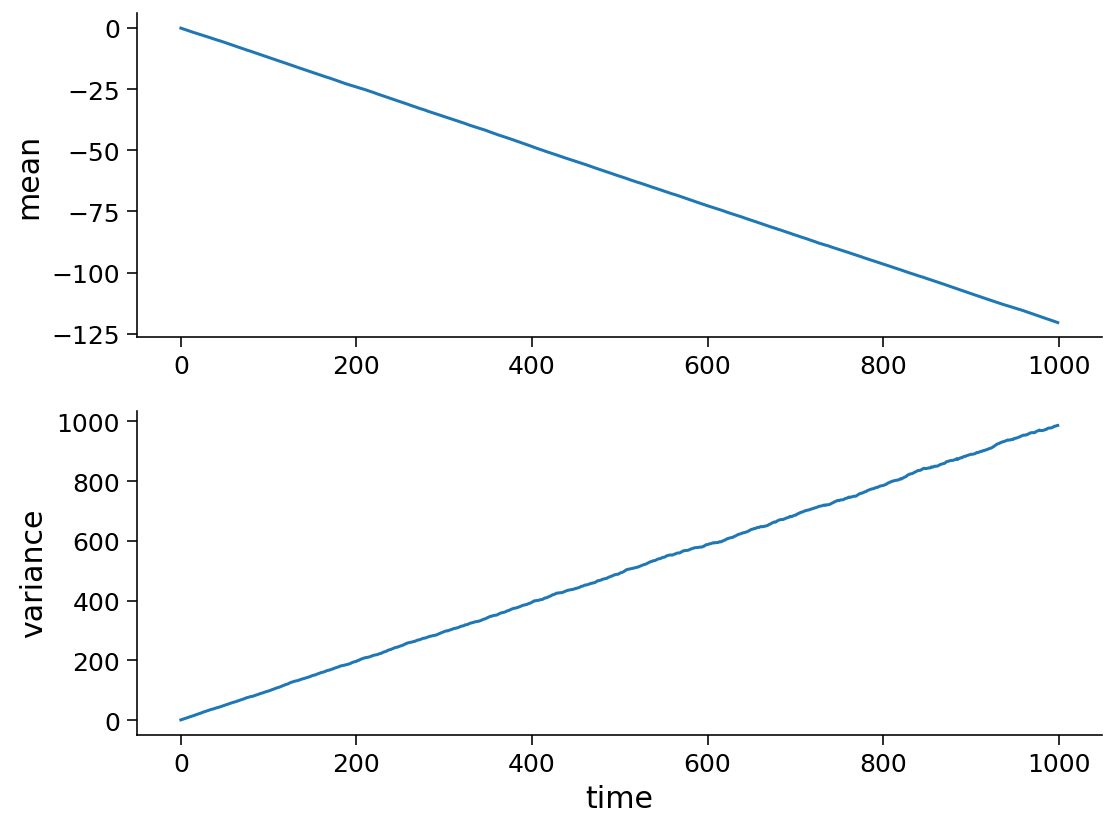

In [16]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

@widgets.interact
def plot_gaussian(mean=(-0.5, 0.5, .02), std=(.5, 10, .5)):
  sim = random_walk_simulator(5000, 1000, mu=mean, sigma=std)

  # compute the mean and variance of trajectory positions at every time point
  mu = np.mean(sim, axis=0)
  var = np.var(sim, axis=0)

  #  make a figure
  fig, (ah1, ah2) = plt.subplots(2)

  # plot mean of distribution as a function of time
  ah1.plot(mu)
  ah1.set(ylabel='mean')

  # plot variance of distribution as a function of time
  ah2.plot(var)
  ah2.set(xlabel='time')
  ah2.set(ylabel='variance')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D2_LinearSystems/solutions/W2D2_Tutorial3_Solution_55aa7188.py)



---
# Section 2: The Ornstein-Uhlenbeck (OU) process

*Estimated timing to here from start of tutorial: 14 min*

In [17]:
# @title Video 2: Combining Deterministic & Stochastic Processes
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1o5411Y7N2", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="pDNfs5p38fI", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

The random walk process we just explored is diffusive, and the distribution of possible trajectories _spreads_, taking on increasing variance with time. Even so, at least in one dimension, the mean remains close to the initial value (in the example above, 0).

Our goal is now to build on this model to construct a **drift-diffusion** model (DDM). DDM is a popular model for memory, which as we all know, is often an exercise in hanging on to a value imperfectly. Decision-making and memory will be the topic for tomorrow, so here we build the mathematical foundations and develop some intuition for how such systems behave!

To build such a model, let's combine the random walk model with the first differential equations we explored in Tutorial 1 earlier. Although those models had been written in continuous time as $\dot{x} = a x$, here let's consider the discrete version of the same system and write:

$x_{k+1} = \lambda x_k$,

whose solution can be written as

$x_k = x_0 \lambda^k$,

where $x_0$ is the value of $x$ at time $t=0$.

Now, let's simulate and plot the solution of the discrete version of our first differential equation from Tutorial 1 below. **Run the code below.**

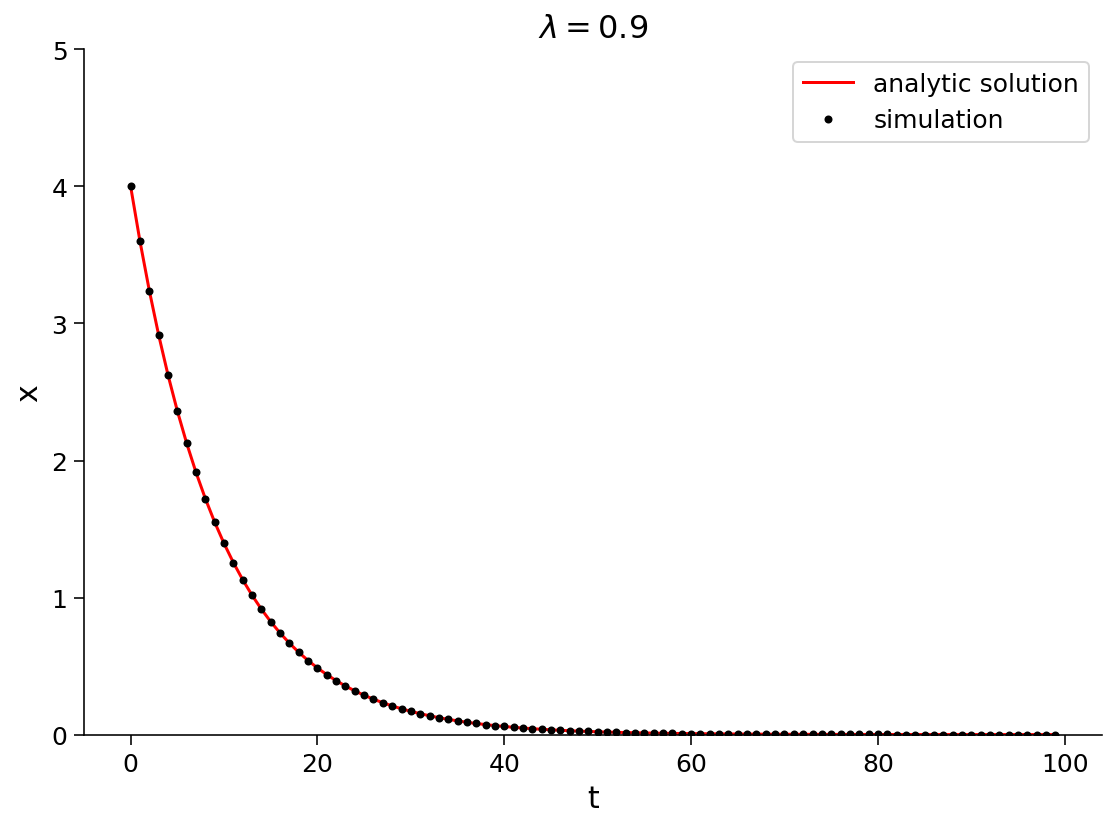

In [20]:
# parameters
lam = 0.9
T = 100      # total Time duration in steps
x0 = 4.     # initial condition of x at time 0

# initiatialize variables
t = np.arange(0, T, 1.)
x = np.zeros_like(t)
x[0] = x0

# Step through in time
for k in range(len(t)-1):
    x[k+1] = lam * x[k]

# plot x as it evolves in time
plot_dynamics(x, t, lam)

Notice that this process decays towards position $x=0$. We can make it decay towards any position by adding another parameter $x_\infty$. The rate of decay is proportional to the difference between $x$ and $x_\infty$. Our new system is

$x_{k+1} = x_\infty + \lambda(x_k - x_{\infty})$ 

We have to modify our analytic solution slightly to take this into account:

$x_k = x_\infty(1 - \lambda^k) + x_0 \lambda^k$.

Let's simulate and plot the dynamics of this process below. Hopefully, we see that it start at $x_0$ and decay towards $x_{\infty}.$


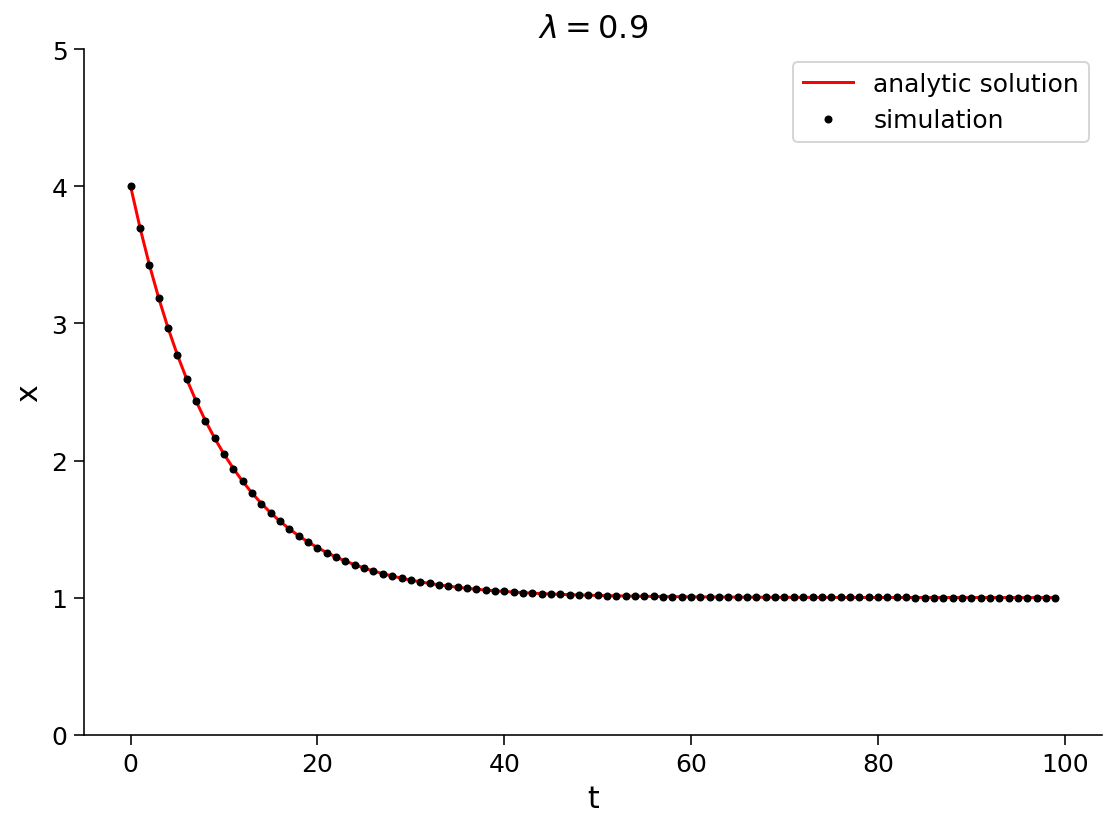

In [21]:
# parameters
lam = 0.9    # decay rate
T = 100      # total Time duration in steps
x0 = 4.      # initial condition of x at time 0
xinfty = 1.  # x drifts towards this value in long time

# initiatialize variables
t = np.arange(0, T, 1.)
x = np.zeros_like(t)
x[0] = x0

# Step through in time
for k in range(len(t)-1):
    x[k+1] = xinfty + lam * (x[k] - xinfty)

# plot x as it evolves in time
plot_dynamics(x, t, lam, xinfty)

Now we are ready to take this basic, deterministic difference equation and add a diffusion process on top of it! Fun times in Python land.

As a point of terminology: this type of process is commonly known as a **drift-diffusion model** or **Ornstein-Uhlenbeck (OU) process**. The model is a combination of a _drift_ term toward $x_{\infty}$ and a _diffusion_ term that walks randomly. You may sometimes see them written as continuous stochastic differential equations, but here we are doing the discrete version to maintain continuity in the tutorial. The discrete version of our OU process has the following form:

$x_{k+1} = x_\infty + \lambda(x_k - x_{\infty}) + \sigma \eta$

where $\eta$ is sampled from a standard normal distribution ($\mu=0, \sigma=1$). 


## Coding Exercise 2: Drift-diffusion model

Modify the code below so that each step through time has a _deterministic_ part (_hint_: exactly like the code above) plus a _random, diffusive_ part that is drawn from from a normal distribution with standard deviation of $\sigma$ (sig in the code). It will plot the dynamics of this process.

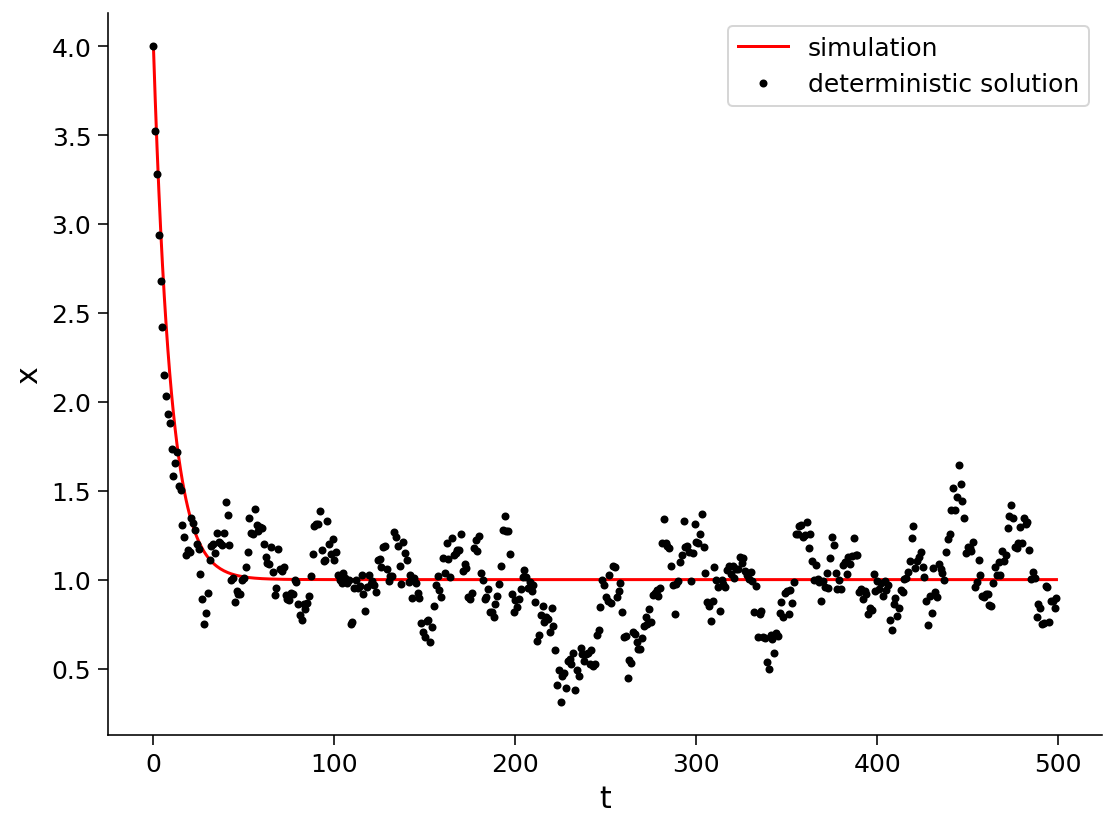

In [24]:
def simulate_ddm(lam, sig, x0, xinfty, T):
  """
  Simulate the drift-diffusion model with given parameters and initial condition.
  Args:
    lam (scalar): decay rate
    sig (scalar): standard deviation of normal distribution
    x0 (scalar): initial condition (x at time 0)
    xinfty (scalar): drift towards convergence in the limit
    T (scalar): total duration of the simulation (in steps)

  Returns:
    ndarray, ndarray: `x` for all simulation steps and the time `t` at each step
  """

  # initiatialize variables
  t = np.arange(0, T, 1.)
  x = np.zeros_like(t)
  x[0] = x0

  # Step through in time
  for k in range(len(t)-1):
      ##############################################################################
      ## TODO: Insert your code below then remove
      #### raise NotImplementedError("Student exercise: need to implement simulation")
      ##############################################################################
      # update x at time k+1 with a determinstic and a stochastic component
      # hint: the deterministic component will be like above, and
      #   the stochastic component is drawn from a scaled normal distribution
      x[k+1] = xinfty + lam * (x[k] - xinfty) + sig * np.random.standard_normal(size=1)

  return t, x

lam = 0.9    # decay rate
sig = 0.1   # standard deviation of diffusive process
T = 500      # total Time duration in steps
x0 = 4.      # initial condition of x at time 0
xinfty = 1.  # x drifts towards this value in long time

# Plot x as it evolves in time
np.random.seed(2020)
t, x = simulate_ddm(lam, sig, x0, xinfty, T)
plot_ddm(t, x, xinfty, lam, x0)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D2_LinearSystems/solutions/W2D2_Tutorial3_Solution_c67c12d7.py)

*Example output:*

<img alt='Solution hint' align='left' width=1120.0 height=832.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D2_LinearSystems/static/W2D2_Tutorial3_Solution_c67c12d7_0.png>



## Think! 2: Drift-Diffusion Simulation Observations

Describe the behavior of your simulation by making some observations. How does it compare to the deterministic solution? How does it behave in the beginning of the stimulation? At the end?

######""ANSWER
The solution follows the deterministic solution on average, especially at
the beginning.
At the end, it follows the analytic solution on average, but there's
non-zero variation around this solution. The next part explores the variance.

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D2_LinearSystems/solutions/W2D2_Tutorial3_Solution_301f6f83.py)



---
# Section 3: Variance of the OU process

*Estimated timing to here from start of tutorial: 35 min*


In [23]:
# @title Video 3: Balance of Variances
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV15f4y1R7PU", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="49A-3kftau0", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

As we can see, the **mean** of the process follows the solution to the deterministic part of the governing equation. So far, so good!

But what about the **variance**? 

Unlike the random walk, because there's a decay process that "pulls" $x$ back towards $x_\infty$, the variance does not grow without bound with large $t$. Instead, when it gets far from $x_\infty$, the position of $x$ is restored, until an equilibrium is reached.

The equilibrium variance for our drift-diffusion system is

Var $= \frac{\sigma^2}{1 - \lambda^2}$.

Notice that the value of this equilibrium variance depends on $\lambda$ and $\sigma$. It does not depend on $x_0$ and $x_\infty$.

To convince ourselves that things are behaving sensibly, let's compare the empirical variances of the equilibrium solution to the OU equations with the expected formula.



## Coding Exercise 3: Computing the variances empirically

Write code to compute the analytical variance: Var $= \frac{\sigma^2}{1 - \lambda^2}$, and compare against the empirical variances (which is already provided for you using the helper function). You should see that they should be about equal to each other and lie close to the 45 degree ($y=x$) line. 

In [22]:
def ddm(T, x0, xinfty, lam, sig):
    t = np.arange(0, T, 1.)
    x = np.zeros_like(t)
    x[0] = x0

    for k in range(len(t)-1):
        x[k+1] = xinfty + lam * (x[k] - xinfty) + sig * np.random.standard_normal(size=1)

    return t, x

# computes equilibrium variance of ddm
# returns variance
def ddm_eq_var(T, x0, xinfty, lam, sig):
    t, x = ddm(T, x0, xinfty, lam, sig)

    # returns variance of the second half of the simulation
    # this is a hack: assumes system has settled by second half
    return x[-round(T/2):].var()

np.random.seed(2020) # set random seed

# sweep through values for lambda
lambdas = np.arange(0.05, 0.95, 0.01)
empirical_variances = np.zeros_like(lambdas)
analytical_variances = np.zeros_like(lambdas)

sig = 0.87

# compute empirical equilibrium variance
for i, lam in enumerate(lambdas):
    empirical_variances[i] = ddm_eq_var(5000, x0, xinfty, lambdas[i], sig)

##############################################################################
## Insert your code below to calculate the analytical variances
raise NotImplementedError("Student exercise: need to compute variances")
##############################################################################

# Hint: you can also do this in one line outside the loop!
analytical_variances = ...

# Plot the empirical variance vs analytical variance
var_comparison_plot(empirical_variances, analytical_variances)

NotImplementedError: ignored

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D2_LinearSystems/solutions/W2D2_Tutorial3_Solution_b972f241.py)

*Example output:*

<img alt='Solution hint' align='left' width=1120.0 height=832.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D2_LinearSystems/static/W2D2_Tutorial3_Solution_b972f241_0.png>



---
# Summary

*Estimated timing of tutorial: 45 minutes*

In this tutorial, we have built and observed OU systems, which have both deterministic and stochastic parts. We see that they behave, on average, similar to our expectations from analyzing deterministic dynamical systems. 

Importantly, **the interplay between the deterministic and stochastic parts** serve to _balance_ the tendency of purely stochastic processes (like the random walk) to increase in variance over time. This behavior is one of the properties of OU systems that make them popular choices for modeling cognitive functions, including short-term memory and decision-making.